# GNN runner
## Mark Tenzer & Jimmy Howerton
## Adapted from code provided with the Spektral package, cited below:
https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py


# Imports

In [1]:
# Base python
import pickle # for loading sparse matrix from disk
import gc     # for garbage collection (RAM management/cleanup)

# Common scientific packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import math

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# TF imports
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
# Spektral imports for GNN
from spektral.layers import GraphConv, GraphSageConv, GINConv

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Config

In [3]:
# Type of graph convolution
Conv = GraphSageConv

# File location to save model
modelfile = "full_models/GraphConv_full.h5"

# Number of graph convolution layers
n_layers = 5

# Number of channels at each conv
channels = 64

# Adjacency matrix of choice
adj_file = "adj/Aboth.pkl"

# Maximum number of training epochs
epochs = 500

# Dropout rate
# dropout_rate = 0.5

# Read the adjacency matrix $A$

#### Load $A$ from disk

In [4]:
with open(adj_file, 'rb') as f:
    A = pickle.load(f)

#### Preprocess $A$ as needed for this GNN convolution technique

In [5]:
fltr = Conv.preprocess(A.astype('float32'))

# Read the data

#### Initial read of file

In [6]:
data = pd.read_csv('~/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={#'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

#### Drop unnecessary columns

In [7]:
data.drop(['Unnamed: 0.1', 'index_x', 'FOD_ID', 'FIRE_NAME', 'DISCOVERY_DOY_SCALED',
           'x_fire', 'y_fire', 'z_fire',
           'index_y', 'Begin', 'End', 'Country', 'Day', 'ICAO', 'Latitude', 'Longitude', 'Month', 'STATION NAME',
           'State', 'Station', 'USAF', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 
           'WBAN', 'Year', 'doy', 'x', 'y', 'z',
          ],
         axis='columns', inplace=True)

#### Sorting so that adjacency matrix is aligned with rows

In [8]:
# data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']
#data = data.sort_values(by=['DAY','LATITUDE','LONGITUDE'])

#### Cleanup memory

In [9]:
gc.collect()

288

In [10]:
data_full = data
data = data[data['FIRE_YEAR']==2015]

In [11]:
data.head()

,STAT_CAUSE_DESCR,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,CONTAINED,DISCOVERY_MONTH,DISTANCE_CITY_1000000,...,Precip,Rain,SeaLevelPressure,Snow,SnowDepth,StationPressure,Temp,Thunder,Visibility,Windspeed
0,Lightning,2015,226,0.10,45.934167,-113.020833,MT,True,8,10.642246,...,0.00,True,1014.9,False,999.9,833.2,73.1,True,10.0,5.6
1,Lightning,2015,232,6313.00,45.515278,-113.245278,MT,False,8,10.569853,...,0.00,False,1009.5,False,999.9,837.1,64.5,False,4.3,9.5
2,Lightning,2015,195,0.25,45.727222,-112.943889,MT,True,7,10.781221,...,0.01,True,1016.2,False,999.9,832.3,58.2,True,10.0,3.9
3,Lightning,2015,226,0.10,45.455556,-113.749722,MT,False,8,10.121757,...,0.01,False,9999.9,False,999.9,877.0,74.6,False,10.0,4.2
4,Miscellaneous,2015,272,0.10,44.416667,-112.843333,MT,True,9,10.995328,...,0.00,False,1016.7,False,999.9,841.3,54.0,False,10.0,7.1


# Preprocess the data

Perform imputation as appropriate; split into train/validation sets.

#### Split into features and labels

In [12]:
Y = pd.get_dummies(data['STAT_CAUSE_DESCR'])
X = pd.get_dummies(data.drop('STAT_CAUSE_DESCR', axis='columns'))

# Number of examples
N = X.shape[0]
# Number of features
F = X.shape[1]

#### Find the missing values, and set to NA

In [13]:
for na in [9999.9, 999.9, 99.99]:
    X[X == na] = np.nan

#### Zero-imputing for some features -- see EDA.ipynb

In [14]:
for zcol in ['Gust', 'MaxWindspeed', 'Precip', 'SnowDepth', 'Visibility', 'Windspeed']:
    X.loc[X[zcol].isna(), zcol] = 0

# Split into training/testing

We'll have three sets of nodes: training nodes, validation nodes, and censored nodes (nodes without valid labels).  Note that this is a semi-supervised problem.

#### Determine which nodes lack valid labels

In [15]:
# Determing which fires fit in these categories
censor = (data['STAT_CAUSE_DESCR'] == 'Missing/Undefined') | (data['STAT_CAUSE_DESCR'] == 'Miscellaneous')

# Drop these levels from the label
Y = Y.drop(['Missing/Undefined', 'Miscellaneous'], axis='columns').values

# Number of classes left
n_classes = Y.shape[1]

In [16]:
labeled_ind  = np.arange(data.shape[0])[~censor]
censor_ind = np.arange(data.shape[0])[censor ]

#### Determine which nodes lack valid labels

In [17]:
train_ind, val_ind = train_test_split(labeled_ind, test_size=0.1, random_state=42)

# "Masks" for training and validation: 1 if in the given set, 0 if not (or no label)
train_mask = np.zeros(N)
train_mask[train_ind] = 1

val_mask = np.zeros(N)
val_mask[val_ind] = 1

#### Mean imputation for the other features -- see EDA.ipynb

In [18]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [19]:
# Make sure to fit only on the training data!  Otherwise the imputation introduces bias
imp.fit(X.values[train_ind, :])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [20]:
# Impute the training and testing values
X = imp.transform(X)

In [21]:
# pd.DataFrame(X).to_csv('Wildfire_Data_X.csv')
# pd.DataFrame(Y).to_csv('Wildfire_Data_Y.csv')

# Define the model

### Model definition

GIN: add "mlp_hidden=\[64\]" parameter to both Conv definitions

GraphSAGE: add "aggregate_op = 'max'" parameter to both Conv definitions

In [22]:
# Input
X_in = Input(shape=(F, ))           # features  for this node
fltr_in = Input((N, ), sparse=True) # adjacency for this node

currentX = X_in

# For each of the specified layers, except the last,
for _ in range(n_layers - 1):

    # Dropout the current layer's inputs
    #currentX = Dropout(dropout_rate)(currentX)
    
    # Graph convolution -- Note that "Conv" type was specified in Config section
    currentX = Conv(channels,
                      activation='relu',aggregate_op = 'max'
                      #kernel_regularizer=l2(0.1),
                      #use_bias=False
                     )([currentX, fltr_in])
    
    #currentX = BatchNormalization()(currentX)

# Final layer: same approach, except:
# instead of n_channels filters, use n_classes so we'll have one probability per class
# instead of ReLU activation     use softmax   so we'll have a probability vector summing to 1
#currentX = Dropout(dropout_rate)(currentX)

output = Conv(n_classes,
              activation='softmax',aggregate_op = 'max'
              #use_bias=False
             )([currentX, fltr_in])

### Model setup

Learning Rate Decay: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

This is only recommended for GIN models

In [23]:
# def step_decay(epoch):
#    initial_lrate = 1e-2
#    drop = 0.5
#    epochs_drop = 50.0
#    lrate = initial_lrate * math.pow(drop,  
#            math.floor((1+epoch)/epochs_drop))
#    return lrate

In [24]:
# class LossHistory(Callback):
#     def on_train_begin(self, logs={}):
#        self.losses = []
#        self.lr = []
 
#     def on_epoch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        self.lr.append(step_decay(len(self.losses)))

In [25]:
callbacks_list = [EarlyStopping(patience=50,  restore_best_weights=True)]
# loss_history = LossHistory()
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [loss_history, lrate, EarlyStopping(patience=50,  restore_best_weights=True)]

In [26]:
# Build model
model = Model(inputs=[X_in, fltr_in], outputs=output)
model.compile(optimizer=Adam(1e-2),
              loss='categorical_crossentropy',
              weighted_metrics=['categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
graph_sage_conv (GraphSageConv) (None, 64)           10688       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_sage_conv_1 (GraphSageCon (None, 64)           8256        graph_sage_conv[0][0]        

# Model fitting

In [27]:
len(val_mask)

74491

In [28]:
# Define validation data
validation_data = ([X, fltr], Y, val_mask)
history = model.fit([X, fltr],
          Y,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N//2,
          validation_data=validation_data,
          shuffle=False)

44us/sample - loss: 1.1372 - categorical_accuracy: 0.6065 - val_loss: 0.1258 - val_categorical_accuracy: 0.6136
Epoch 388/500
74491/74491 [==============================] - 3s 44us/sample - loss: 1.1340 - categorical_accuracy: 0.6134 - val_loss: 0.1259 - val_categorical_accuracy: 0.6074
Epoch 389/500
74491/74491 [==============================] - 3s 45us/sample - loss: 1.1336 - categorical_accuracy: 0.6132 - val_loss: 0.1260 - val_categorical_accuracy: 0.6088
Epoch 390/500
74491/74491 [==============================] - 3s 45us/sample - loss: 1.1350 - categorical_accuracy: 0.6078 - val_loss: 0.1262 - val_categorical_accuracy: 0.6060
Epoch 391/500
74491/74491 [==============================] - 3s 45us/sample - loss: 1.1361 - categorical_accuracy: 0.6120 - val_loss: 0.1269 - val_categorical_accuracy: 0.5978
Epoch 392/500
74491/74491 [==============================] - 3s 44us/sample - loss: 1.1426 - categorical_accuracy: 0.5972 - val_loss: 0.1273 - val_categorical_accuracy: 0.5892
Epoch 39

In [ ]:
gc.collect()

# Plot training history

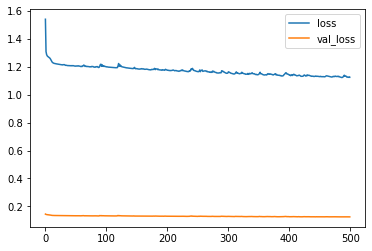

In [29]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
plt.show()

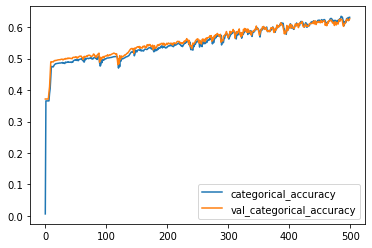

In [30]:
fig, ax = plt.subplots()
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
ax.legend()
plt.show()

Show learning rate for GIN models

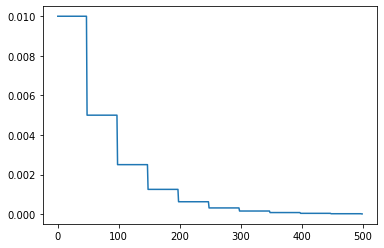

In [54]:
# plt.plot(loss_history.lr)

# Save model to disk

In [53]:
model.save(modelfile)